<a href="https://colab.research.google.com/github/H-Zouari/Property_Price_PredictionML/blob/main/Bejing_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold

# Get the data

In [3]:
CSV_files = ['/content/drive/MyDrive/Colab_Notebooks/ML/Data/Beijing.csv']

def load_file(*CSV_files):
  dataframes_list = []
  for file in CSV_files:
    if len(CSV_files) == 1:
      df = pd.read_csv(file,encoding = 'unicode_escape', engine ='python')
      return df
    else:
      temp_df = pd.read_csv(file)
      dataframes_list.append(temp_df)
      return dataframes
initial = load_file(*CSV_files)

# Split data into train and test set

In [4]:
def find_categorical(df,threshold):
  return df.columns[df.nunique() < threshold].tolist()

In [5]:
def check_nulls(df,upper):
  null_value_count = df.isnull().sum()
  cols = df.columns[(null_value_count > 0) & (null_value_count < upper)].tolist()
  return cols

In [6]:
initial = initial.dropna(subset=check_nulls(initial,3000), how='any')

In [7]:
cat_columns = ['buildingType','renovationCondition','buildingStructure',
               'subway','fiveYearsProperty', 'district','elevator']

In [8]:
for col in cat_columns:
  print(initial.groupby(col, as_index= False).size())

   buildingType    size
0           1.0   84485
1           2.0      59
2           3.0   59676
3           4.0  172228
   renovationCondition    size
0                    1  117911
1                    2    5211
2                    3   76775
3                    4  116551
   buildingStructure    size
0                  1      45
1                  2  115273
2                  3      79
3                  4   14018
4                  5     156
5                  6  186877
   subway    size
0     0.0  125742
1     1.0  190706
   fiveYearsProperty    size
0                0.0  111805
1                1.0  204643
    district    size
0          1   16922
1          2   29275
2          3    2444
3          4   15066
4          5    2666
5          6   38024
6          7  106794
7          8   38141
8          9   11342
9         10   31100
10        11   13939
11        12    1681
12        13    9054
   elevator    size
0       0.0  132943
1       1.0  183505


In [9]:
def find_scarce_categories(df,threshold):
  scarce_cat = {}
  length = len(df)
  for col in cat_columns:
    temp =  initial.groupby(col, as_index= False).size()
    temp['size'] = temp['size'].apply(lambda i: i/len(initial))
    mask = temp['size'] <= threshold
    if not temp[mask].empty:
      attribute = temp[mask].columns[0]
      cat_values = temp[mask].values[:,0]
      scarce_cat[attribute] = cat_values
  return scarce_cat

In [10]:
def drop_scarce_categories(df):
  dic = find_scarce_categories(df,0.005)
  for key, val in dic.items():
    for i in range(len(val)):
      df.drop(df.loc[df[key]== val[i]].index, inplace= True)
  return df

In [11]:
initial = drop_scarce_categories(initial)

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(initial, test_size=0.1, random_state=60)

# Initial overview:
Suburb, address ,regionname and postcode all describe more or less a similar metric i.e location.
It remains to be seen which one is more closely related to price and this will be analysed later on.

In [ ]:
initial.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,131.00,2,1,1,1,¸ß 26,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,132.38,2,2,1,2,¸ß 22,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,198.00,3,2,1,3,ÖÐ 4,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,134.00,3,1,1,1,µ× 21,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,81.00,2,1,1,1,ÖÐ 6,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


## Data info:
Null values are present in the price attribute as number non null count < row count.


In [ ]:
initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  livingRoom           318851 non-null  object 
 12  drawingRoom          318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

In [ ]:
initial.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'floor', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage'],
      dtype='object')

In [ ]:
to_drop = ['url','Cid','id']
initial = initial.drop(columns= to_drop ,axis = 1)

In [ ]:
df = initial.copy()
df.select_dtypes(include=['object'])



,tradeTime,livingRoom,drawingRoom,bathRoom,floor,constructionTime
0,2016-08-09,2,1,1,¸ß 26,2005
1,2016-07-28,2,2,2,¸ß 22,2004
2,2016-12-11,3,2,3,ÖÐ 4,2005
3,2016-09-30,3,1,1,µ× 21,2008
4,2016-08-28,2,1,1,ÖÐ 6,1960
...,...,...,...,...,...,...
318846,2016-06-10,3,2,2,ÖÐ 5,2003
318847,2016-06-10,1,0,1,ÖÐ 24,2009
318848,2016-06-05,2,2,2,ÖÐ 7,2000
318849,2016-06-12,4,2,2,ÖÐ 5,2003


In [ ]:
df.isnull().sum()


Lng                         0
Lat                         0
tradeTime                   0
DOM                    157977
followers                   0
totalPrice                  0
price                       0
square                      0
livingRoom                  0
drawingRoom                 0
kitchen                     0
bathRoom                    0
floor                       0
buildingType             2021
constructionTime            0
renovationCondition         0
buildingStructure           0
ladderRatio                 0
elevator                   32
fiveYearsProperty          32
subway                     32
district                    0
communityAverage          463
dtype: int64

In [ ]:
initial['DOM'].describe()

count    160874.000000
mean         28.822339
std          50.237343
min           1.000000
25%           1.000000
50%           6.000000
75%          37.000000
max        1677.000000
Name: DOM, dtype: float64

We can see that the number of null values in other columns is insignificant so we will be dropping these rows.

In [ ]:
df.isnull().sum()/len(df)

Lng                    0.000000
Lat                    0.000000
tradeTime              0.000000
DOM                    0.495457
followers              0.000000
totalPrice             0.000000
price                  0.000000
square                 0.000000
livingRoom             0.000000
drawingRoom            0.000000
kitchen                0.000000
bathRoom               0.000000
floor                  0.000000
buildingType           0.006338
constructionTime       0.000000
renovationCondition    0.000000
buildingStructure      0.000000
ladderRatio            0.000000
elevator               0.000100
fiveYearsProperty      0.000100
subway                 0.000100
district               0.000000
communityAverage       0.001452
dtype: float64

## Visualize and gain insight into the Data

In [ ]:
initial.head()

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,116.475489,40.019520,2016-08-09,1464.0,106,415.0,31680,131.00,2,1,1,1,¸ß 26,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,116.453917,39.881534,2016-07-28,903.0,126,575.0,43436,132.38,2,2,1,2,¸ß 22,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,116.561978,39.877145,2016-12-11,1271.0,48,1030.0,52021,198.00,3,2,1,3,ÖÐ 4,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,116.438010,40.076114,2016-09-30,965.0,138,297.5,22202,134.00,3,1,1,1,µ× 21,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,116.428392,39.886229,2016-08-28,927.0,286,392.0,48396,81.00,2,1,1,1,ÖÐ 6,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


### Visualizing Geographical Data
Since we have the coordinates for each location, its good to visualize the distribution of districts

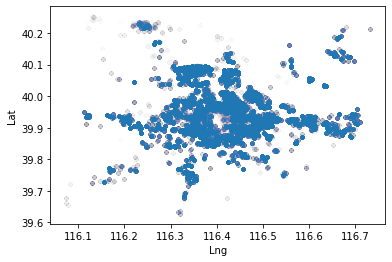

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
initial.plot(kind="scatter", x="Lng", y="Lat",alpha=0.002)

## Median initial price in each district with geographical distribution 
As we can see here, high cost initial clusters around the city center, decreasing towards the outskirts of the city. 

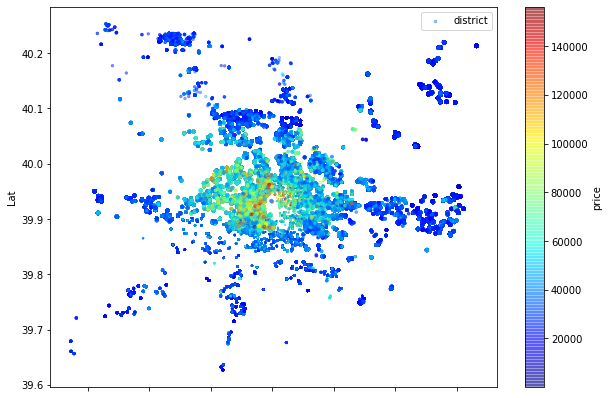

In [ ]:
%matplotlib inline
initial.plot(kind="scatter", x="Lng", y="Lat", alpha=0.4,
 s=initial["district"], label="district", figsize=(10,7),
 c="price", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

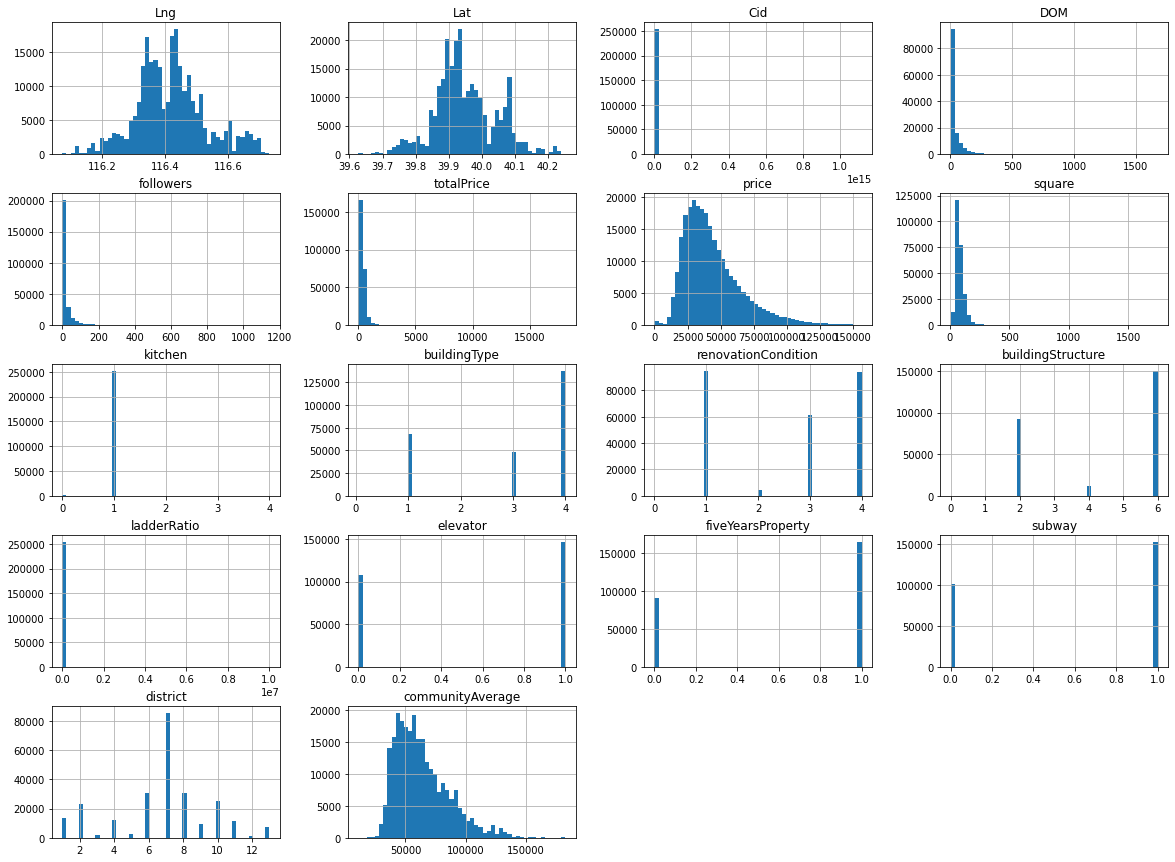

In [ ]:
%matplotlib inline
initial.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
corr_matrix = initial.corr()
corr_matrix["price"].sort_values(ascending=False)

price                  1.000000
communityAverage       0.683582
totalPrice             0.623748
renovationCondition    0.295664
followers              0.259670
subway                 0.231594
DOM                    0.215091
elevator               0.051719
buildingStructure      0.044280
district               0.033013
fiveYearsProperty      0.014134
kitchen                0.013895
Cid                   -0.000278
ladderRatio           -0.000554
buildingType          -0.049441
Lat                   -0.051858
Lng                   -0.151481
square                -0.163119
Name: price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea6d2a68d0>,
      dtype=object)

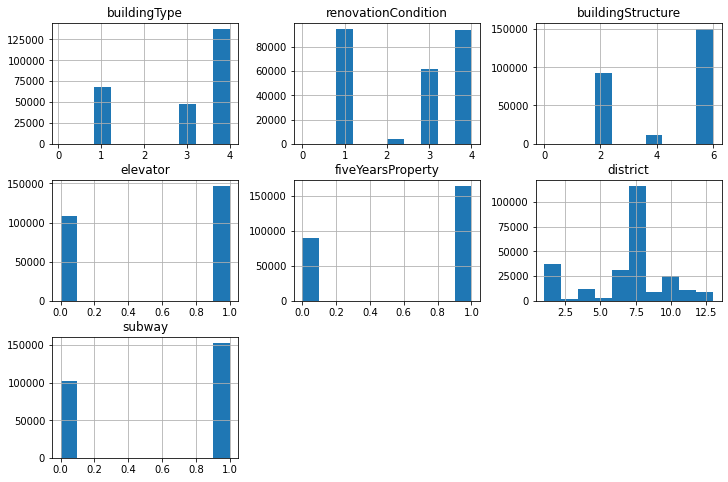

In [ ]:
categorical = ['buildingType','renovationCondition','buildingStructure','elevator','fiveYearsProperty','district','subway']
initial[categorical].hist(figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea6d2b1a50>,
      dtype=object)

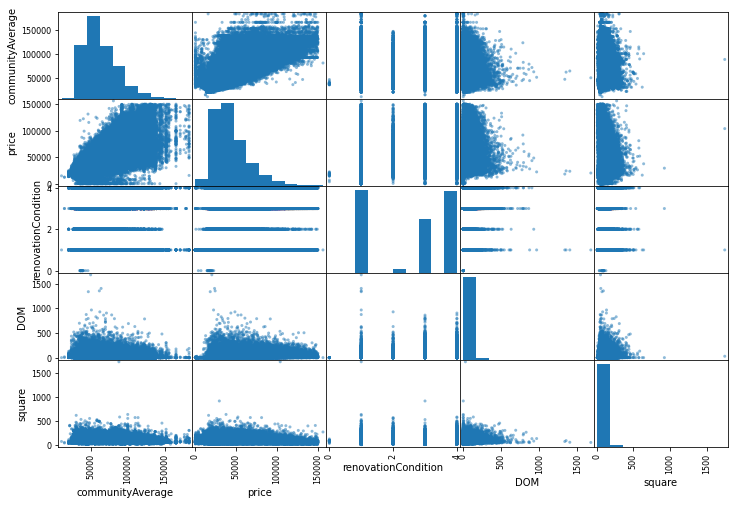

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["communityAverage", "price", "renovationCondition","DOM","square"]
scatter_matrix(initial[attributes], figsize=(12, 8))

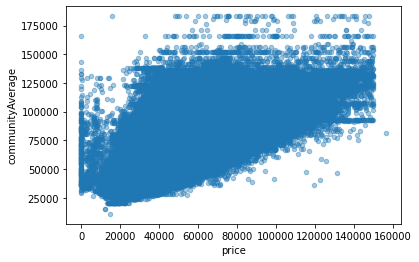

In [ ]:
initial.plot(kind="scatter", x="price", y="communityAverage",
 alpha=0.4)

# Prepare Data for machine learning

In [13]:
housing = train_set.drop("price", axis=1) # drop labels for training set
housing_labels = train_set["price"].copy()

In [14]:
def drop_col(X): 
  ''' drop unrelated columns'''
  print('dropped')
  return X.drop(to_drop,axis= 1)

In [15]:

def helper(val): 
  ''' Floor columns contain non unicode letters
  this function returns the integer part of the floor elements'''
  item = val.split()
  if len(item) == 2:
    out = int(item[1])
    return out
  else:
    out = 0
    return out
def fix_unicode(X):
  print('col floor fixed')
  return X.applymap(lambda val: helper(val))

In [16]:
from functools import partial
def convert_int(X):
  ''' convert strings to integers'''
  print('objects converted') #this allows the tracking of the pipeline progress
  return X.applymap(partial(pd.to_numeric, errors='coerce'))

In [17]:
def custom_OHE(X):
  ''' created custom OneHotEncoder to keep feature names for later analysis'''
  print('OHE')
  df_imputed = X.apply(lambda val: val.fillna(val.value_counts().index[0]))
  return pd.get_dummies(df_imputed, columns= df_imputed.columns)

In [18]:
def tradetime(X):
  dateform = pd.to_datetime(X['tradeTime'])
  X['year_of_sale']=  dateform.dt.year
  return np.matrix(X)[:,1]

In [50]:
def haversine(Dlat,Dlon):
    radius = 6371.  # km
    Olat = 116.451  # latitude and logitude of Beijing city center 
    Olon = 39.9334
    d_lat = np.radians(Dlat - Olat)
    d_lon = np.radians(Dlon - Olon)
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    d = radius * c
    return d
def add_distance(X):
  X['distance']= haversine(X['Lat'],X['Lng'])
  return np.matrix(X)

In [51]:
to_drop = ['url', 'id','Cid','Lat','Lng','tradeTime']

non_unicode = ['floor']

object_columns = ['livingRoom', 'drawingRoom', 'bathRoom', 'constructionTime']

coordinates = ['Lat','Lng']

num_columns = ['DOM', 'followers', 'totalPrice',
               'square', 'communityAverage']

cat_columns = ['buildingType','renovationCondition','buildingStructure',
               'subway','fiveYearsProperty', 'district','elevator']

In [52]:
drop_pipeline = make_pipeline(FunctionTransformer(drop_col))

non_unicode_pipeline = make_pipeline(FunctionTransformer(fix_unicode),
                                     SimpleImputer(missing_values=np.NaN,
                                                   strategy= 'most_frequent')
                                     )

convert_pipeline =  make_pipeline(FunctionTransformer(convert_int),
                                  SimpleImputer(missing_values=np.NaN,
                                                strategy= 'most_frequent')
                                  )

year_of_sale_pipeline = make_pipeline(FunctionTransformer(tradetime))

add_distance_pipeline = make_pipeline(FunctionTransformer(add_distance),
                                      StandardScaler())

num_pipeline = make_pipeline(SimpleImputer(missing_values=np.NaN, 
                                           strategy='median'), 
                             StandardScaler()
                                           )

cat_pipeline = make_pipeline(FunctionTransformer(custom_OHE))

transformers = [
                ('drop', drop_pipeline, to_drop),
                ('unicode', non_unicode_pipeline, non_unicode),
                ('convert', convert_pipeline, object_columns),
                ('add_year_of_sale', year_of_sale_pipeline, ['tradeTime']),
                ('distance',add_distance_pipeline,coordinates), 
                ('num', num_pipeline, num_columns),
                ('cat', cat_pipeline, cat_columns),
               ]

combined_pipe = ColumnTransformer(transformers, remainder='drop')

transformed_data = combined_pipe.fit_transform(housing)

dropped
col floor fixed
objects converted
OHE


In [53]:
import sklearn
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [ ]:
get_feature_names(combined_pipe)[3:]

In [ ]:
transformed_data.shape

# Select and train model

In [57]:
from sklearn.tree import DecisionTreeRegressor


tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(transformed_data,housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [58]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(transformed_data)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0013255979148823567

# Fine-tune your model

In [59]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, transformed_data, housing_labels,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

In [60]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 844.3980526   838.10589586  907.77397511 1209.30454095  803.15196545]
Mean: 920.546885995031
Standard deviation: 148.2706036933914


**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).

In [61]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(transformed_data, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [62]:
housing_predictions = forest_reg.predict(transformed_data)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

250.9696051395519

In [63]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, transformed_data, housing_labels,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [766.0145728  818.52229014 856.64420409 921.96133612 543.71334641]
Mean: 781.3711499141498
Standard deviation: 129.25083859688195


In [377]:
import xgboost as xgb


xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

fitx = xg_reg.fit(housing,housing_labels)
predx = 


' from sklearn.svm import SVR\n\nsvm_reg = SVR(kernel="linear")\nsvm_reg.fit(transformed_data, housing_labels)\nhousing_predictions = svm_reg.predict(transformed_data)\nsvm_mse = mean_squared_error(housing_labels, housing_predictions)\nsvm_rmse = np.sqrt(svm_mse)\nsvm_rmse '

The best hyperparameter combination found:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [20 ,30 , 40], 'max_features': [10,20,30,43]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(transformed_data, housing_labels)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=30, high=200),
        'max_features': randint(low=8, high=43),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=10, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(transformed_data, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
attributes = get_feature_names(combined_pipe)[3:]
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

X_test_prepared = combined_pipe.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

We could compute the interval manually like this:

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

Alternatively, we could use a z-scores rather than t-scores:

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

In [ ]:
!git status